In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
%matplotlib inline
colors = sns.color_palette('Set1', 9)

In [2]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as gmm
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('Player_Data.csv')
ocols = [x for x in df.columns if x.startswith('o_')]
dcols = [x for x in df.columns if x.startswith('d_')]

# Get the columns to perform K-means on
Xo = df[ocols].values
Xd = df[dcols].values

# Normalize values to 0 mean and 1 standard deviation
Xo_norm = StandardScaler().fit_transform(Xo)
Xd_norm = StandardScaler().fit_transform(Xd)

In [78]:
def elbow(k_max, X, title):
    f, ax = plt.subplots(1, 1)
    elbow = {}
    for k in range(2,k_max):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        elbow[k] = kmeans.inertia_
    sns.pointplot(x=list(elbow.keys()), y=list(elbow.values()),
                  color=colors[0], ax=ax)
    ax.set_title(title)
    ax.set(xlabel='Clusters', ylabel='Sum of Squared Distances')

In [75]:
def aicBic(k_max, X, title):
    f, ax = plt.subplots(1, 1)
    aic = {}
    bic = {}
    for k in range(2,k_max):
        gm = gmm(n_components=k, random_state=0).fit(X)
        aic[k] = gm.aic(X)
        bic[k] = gm.bic(X)
    sns.pointplot(x=list(aic.keys()), y=list(aic.values()),
                  color=colors[0], ax=ax)
    sns.pointplot(x=list(bic.keys()), y=list(bic.values()),
                  color=colors[1], ax=ax)
    ax.set_title(title)
    ax.set(xlabel='Clusters', ylabel='IC Score')
    ax.legend(handles=ax.lines[::len(aic.keys())+1],
              labels=["AIC","BIC"])

In [84]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

def sil_scores(n, X, title, algo='Kmeans'):
    scores = {}
    for k in range(2, n):
        if algo=='Kmeans':
            kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
            labels = kmeans.labels_
        elif algo=='GMM':
            gm = gmm(n_components=k, random_state=0).fit(X)
            labels = gm.predict(X)
        scores[k] = silhouette_score(X, labels)
    f, ax = plt.subplots(1, 1)
    sns.pointplot(x=list(scores.keys()), y=list(scores.values()),
                  color=colors[0], ax=ax)
    ax.set_title(title)
    ax.set(xlabel='Clusters', ylabel='Silhouette Score')

In [101]:
def silhouette(k, X, title, algo='Kmeans'):
    if algo=='Kmeans':
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
    elif algo == 'GMM':
        gm = gmm(n_components=k, random_state=0).fit(X)
        labels = gm.predict(X)
        centers = gm.means_
    sil_av = silhouette_score(X, labels)
    sil_samp = silhouette_samples(X, labels)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    y_lower = 10
    c_dict = {}
    for i in range(k):
        sil_vals = sil_samp[labels == i]
        sil_vals.sort()
        clust_size = sil_vals.shape[0]
        y_upper = y_lower + clust_size
        color = colors[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, sil_vals, facecolor=color,
                         edgecolor=color, alpha=.78)
        ax1.text(-0.05, y_lower + 0.5 * clust_size, str(i))
        y_lower = y_upper + 10
        c_dict[i] = colors[i]
    ax1.axvline(x=sil_av, color="red", linestyle="--")
    ax1.set_title('Silhouette Plot')
    ax1.set(xlabel='Silhouette Coefficient Values', ylabel='Cluster Label')
    ax1.set_yticks([])

    colors2 = [colors[x] for x in labels]
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors2, edgecolor='k')
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
        
    ax2.set_title("Clustered Data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    plt.suptitle((title),
                 fontsize=13, fontweight='bold')

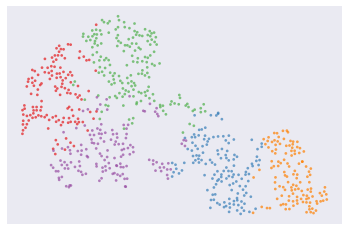

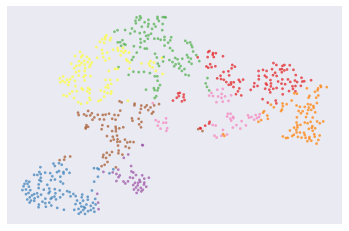

In [214]:
from sklearn.manifold import TSNE

def plotTSNE(X, labels):
    xembed = TSNE().fit_transform(X)
    f, ax = plt.subplots(1,1)
    colors2 = [colors[x] for x in labels]
    ax.scatter(xembed[:,0], xembed[:,1], marker='.', s=30, lw=0, alpha=.7, edgecolor='k',c=colors2)
    ax.set_yticks([])
    ax.set_xticks([])

plotTSNE(dfpcad[['PC1', 'PC2', 'PC3']].values, df['PCA_Cluster_D'].values)
plotTSNE(dfpcao[['PC1', 'PC2', 'PC3']].values, df['PCA_Cluster_O'].values)

In [386]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA

def transformDF(X, trans, n=0):
    
    if trans == 'PCA':
        f, ax = plt.subplots(1, 1)
        n = len(X[0])
        pca = PCA(n_components=n, random_state=0)
        cols = ['PC'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(pca.fit_transform(X), columns=cols)

        sns.pointplot(y=pca.explained_variance_ratio_,
                    x=[x for x in range(1,n+1)], color=colors[0],
                      ax=ax)
        sns.pointplot(y=np.cumsum(pca.explained_variance_ratio_),
                      x=[x for x in range(1,n+1)], color=colors[1],
                      ax=ax)

        ax.legend(
            handles=ax.lines[::len(pca.explained_variance_ratio_)+1],
                  labels=["Variance Explained","Cumulative Variance Explained"])
        
    elif trans == 'ICA':
        f, ax = plt.subplots(1, 1)
        ica = ICA(n_components=n, random_state=0)
        cols = ['IC'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(ica.fit_transform(X), columns=cols)
        dft = dft[dft.kurt(axis=0).abs().sort_values(ascending=False).index]
        sns.barplot(x=dft.kurt(axis=0).abs().sort_values(ascending=False), y=dft.columns,
                    color=colors[0], ax=ax)
        dft = dft[dft.kurt(axis=0).abs().sort_values(ascending=False).iloc[:-int(n/2)].index]
        
    elif trans == 'RCA':
        rca = RP(n_components=n, random_state=0)
        cols = ['RC'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(rca.fit_transform(X), columns=cols)
        
    elif trans == 'FA':
        fa = FA(n_clusters=n)
        cols = ['FA'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(fa.fit_transform(X), columns=cols)
        
    return dft

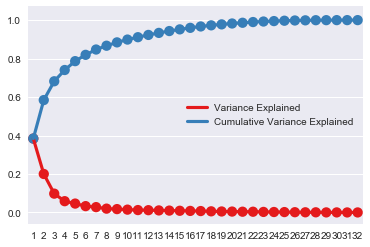

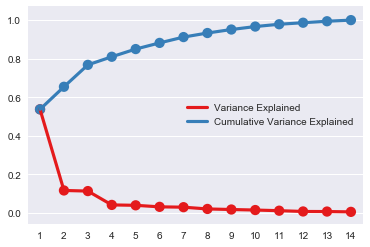

In [115]:
dfpcao = transformDF(Xo_norm, 'PCA')
dfpcad = transformDF(Xd_norm, 'PCA')

In [117]:
from sklearn.decomposition import FastICA as ICA

def elbowICA(X):
    elbow_all = {}
    elbow_top = {}
    n = len(X[0])
    f, ax = plt.subplots(1, 1)
    
    for k in range(2,n+1):
        df = pd.DataFrame(ICA(n_components=k, random_state=0).fit_transform(X))
        dfkurt = df.kurt(axis=0)
        elbow_all[k] = dfkurt.abs().mean()
        elbow_top[k] = dfkurt.abs().sort_values().iloc[int(k/2):].mean()
        
    sns.pointplot(x=list(elbow_all.keys()), y=list(elbow_all.values()),
                  color=colors[0], ax=ax)
    sns.pointplot(x=list(elbow_top.keys()), y=list(elbow_top.values()),
                  color=colors[1], ax=ax)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


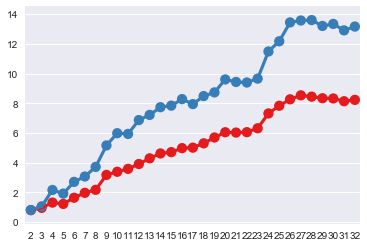

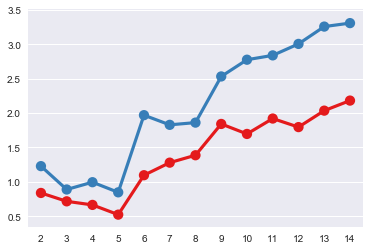

In [118]:
elbowICA(Xo_norm)
elbowICA(Xd_norm)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


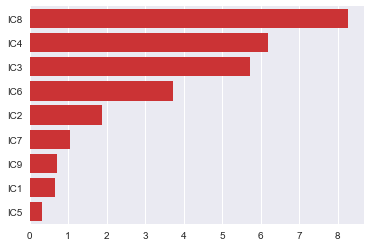

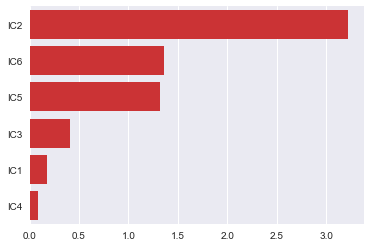

In [119]:
dficao = transformDF(Xo_norm, 'ICA', 9)
dficad = transformDF(Xd_norm, 'ICA', 6)

In [382]:
from sklearn.random_projection import GaussianRandomProjection as RP

def reconstructError(obj, X):
    if 'FeatureAgglomeration' in str(type(obj)):
        x_trans = obj.fit_transform(X)
        X_project = obj.inverse_transform(x_trans)
    elif 'GaussianRandomProjection' in str(type(obj)):
        X_trans = obj.fit_transform(X)
        mean = X.mean(axis=0)
        X_project = np.dot(X_trans, obj.components_) + mean
    return ((X - X_project) ** 2).mean()

def elbowRCA(X, title):
    df = pd.DataFrame()
    n = len(X[0])
    f, ax = plt.subplots(1, 1)
    for s in range(30):
        for k in range(2,n+1):
            df = df.append({'Reconstruction Error':reconstructError(RP(n_components=k,
                                                                       random_state=s), X),
                            'Components': int(k)}, ignore_index=True)
    df['Components'] = df['Components'].astype(int)
    sns.pointplot(x='Components', y='Reconstruction Error', data=df, scale=.75, markers='.',
                  color=colors[0], ax=ax)
    ax.set_title(title)

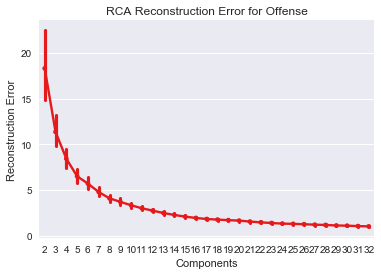

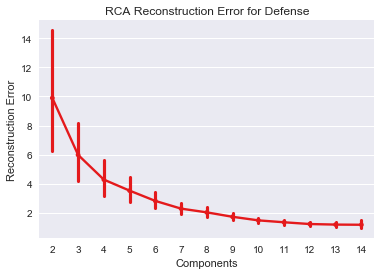

In [378]:
elbowRCA(Xo_norm, 'RCA Reconstruction Error for Offense')
elbowRCA(Xd_norm, 'RCA Reconstruction Error for Defense')

In [362]:
dfrcao = transformDF(Xo_norm, 'RCA', 6)
dfrcad = transformDF(Xd_norm, 'RCA', 4)

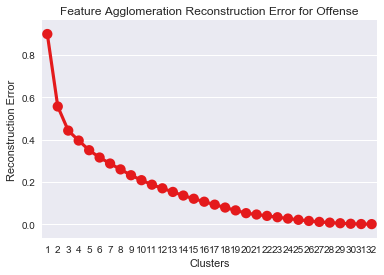

In [384]:
from sklearn.cluster import FeatureAgglomeration as FA

def elbowFA(X, title):
    df = pd.DataFrame()
    n = len(X[0])
    f, ax = plt.subplots(1, 1)
    for k in range(1,n+1):
        df = df.append({'Reconstruction Error':reconstructError(FA(n_clusters=k), X),
                        'Clusters': int(k)}, ignore_index=True)
    df['Clusters'] = df['Clusters'].astype(int)
    sns.pointplot(x='Clusters', y='Reconstruction Error', data=df,
                  color=colors[0], ax=ax)
    ax.set_title(title)

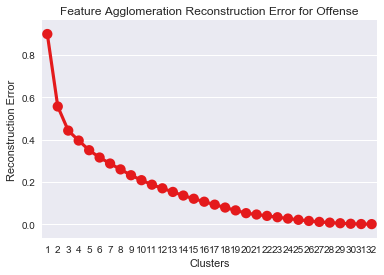

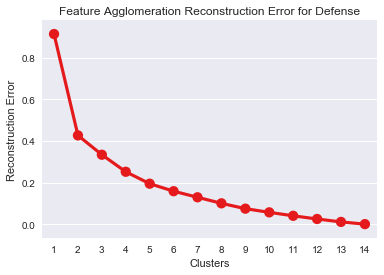

In [385]:
elbowFA(Xo_norm, 'Feature Agglomeration Reconstruction Error for Offense')
elbowFA(Xd_norm, 'Feature Agglomeration Reconstruction Error for Defense')

In [387]:
dffao = transformDF(Xo_norm, 'FA', 5)
dffad = transformDF(Xd_norm, 'FA', 5)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


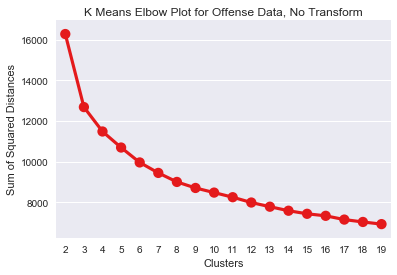

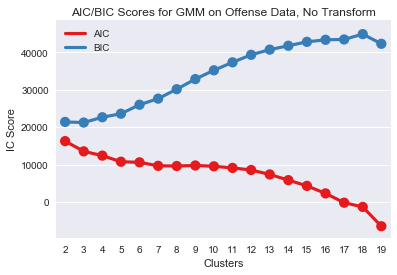

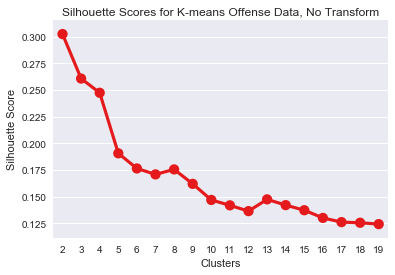

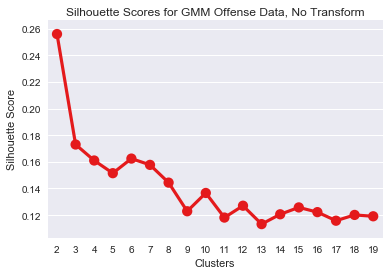

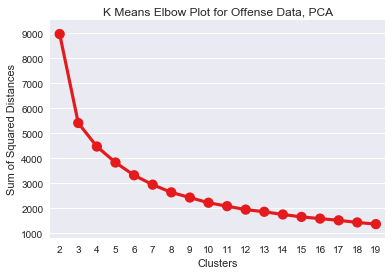

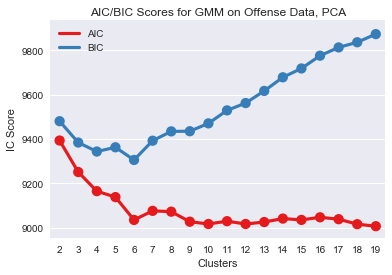

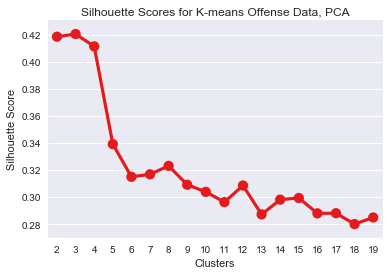

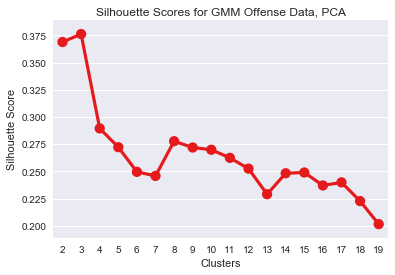

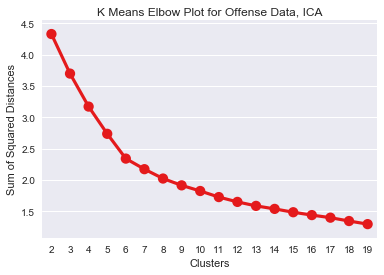

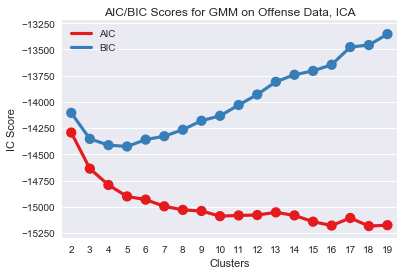

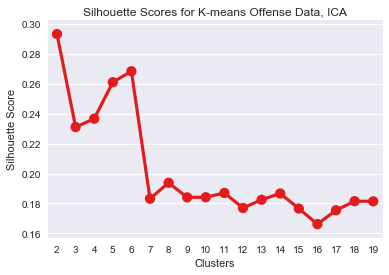

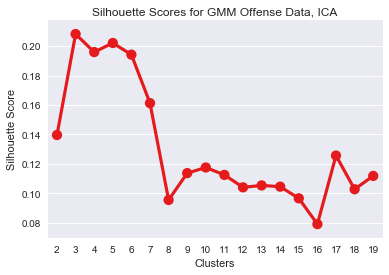

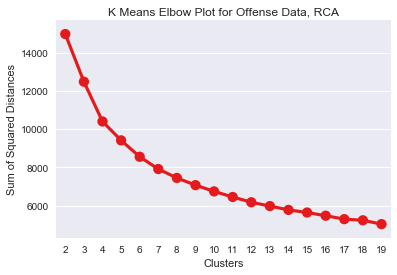

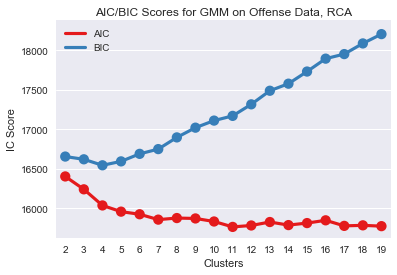

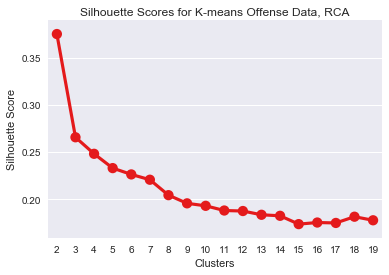

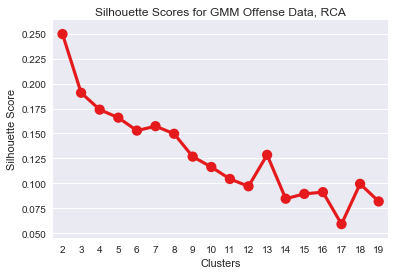

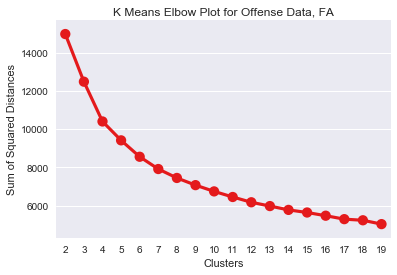

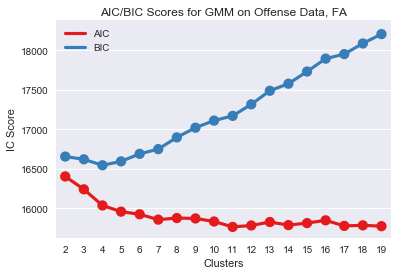

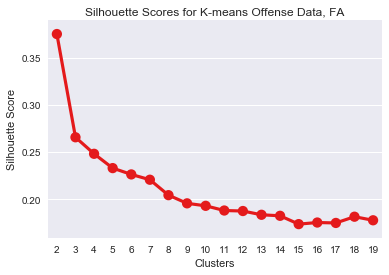

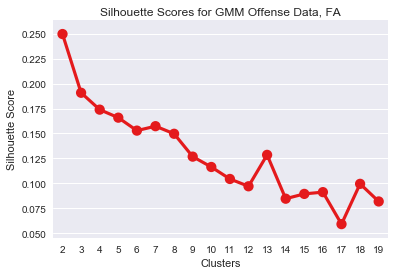

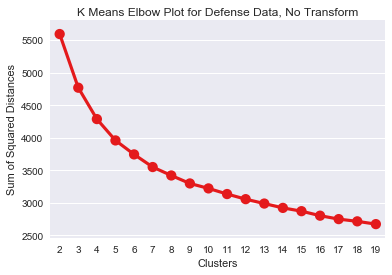

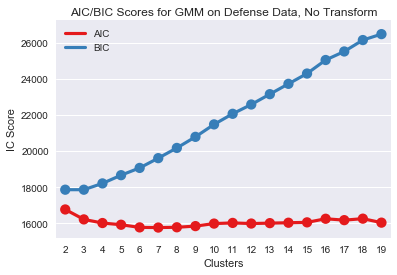

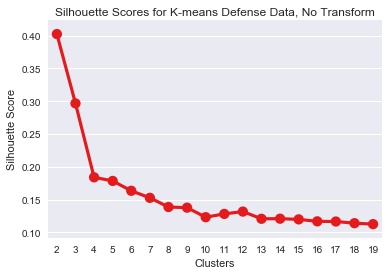

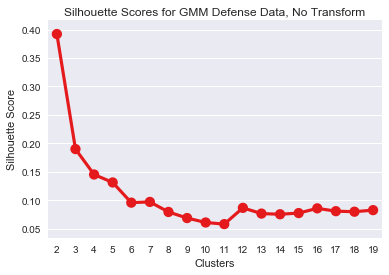

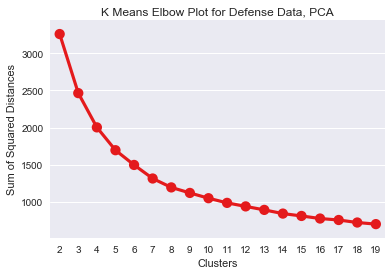

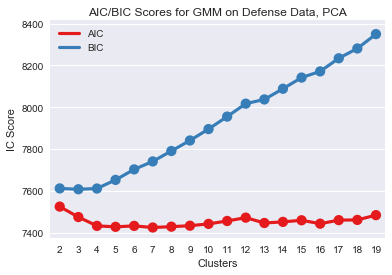

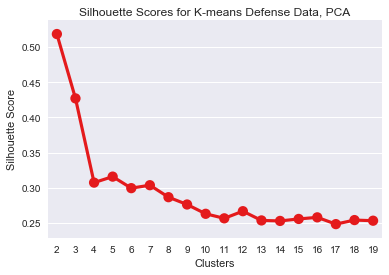

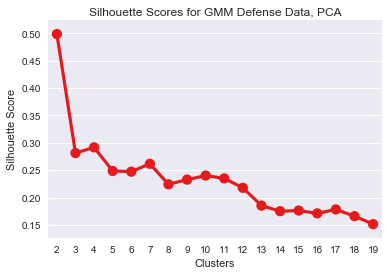

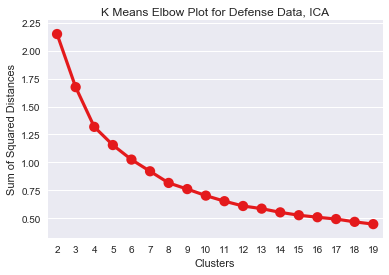

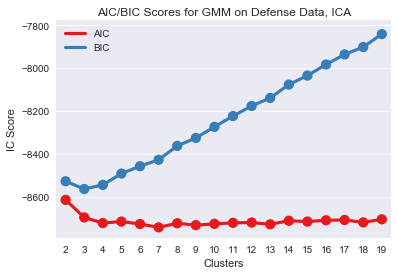

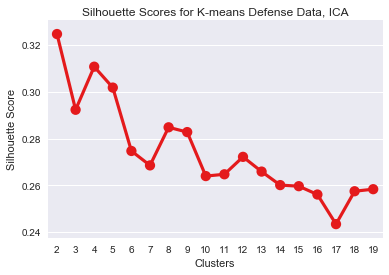

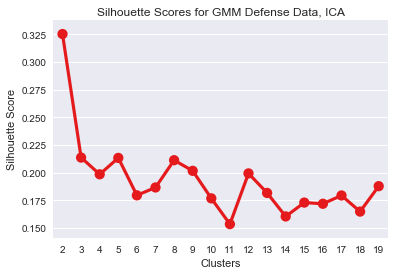

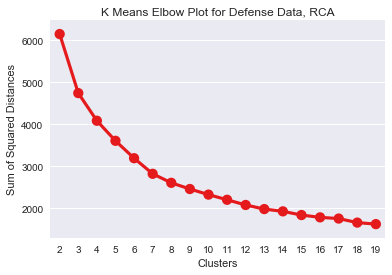

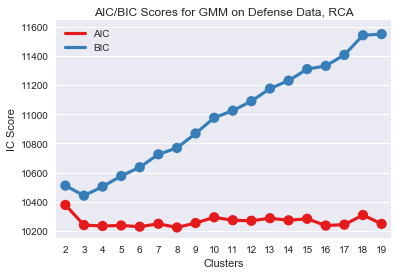

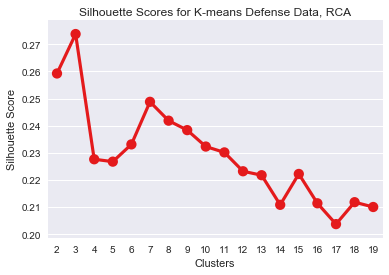

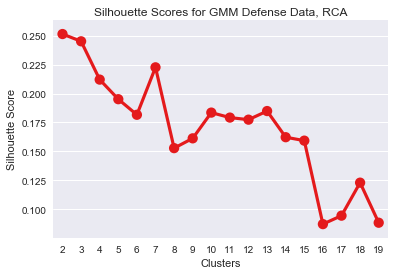

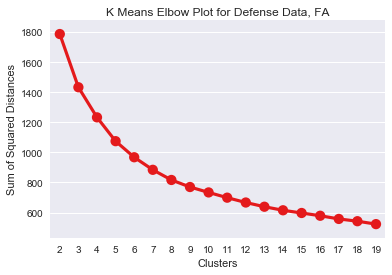

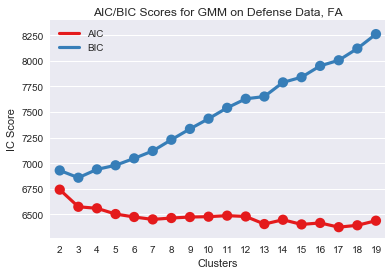

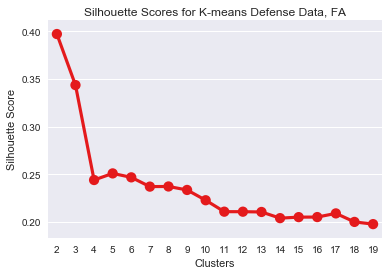

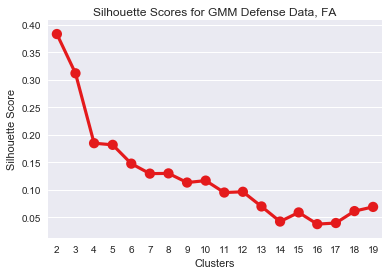

In [388]:
data_dict = {'Offense':{'No Transform':Xo_norm,
                        'PCA':dfpcao[['PC1', 'PC2', 'PC3']].values,
                        'ICA':dficao.values,
                        'RCA':dfrcao.values,
                        'FA':dfrcao.values
                       },
             'Defense':{'No Transform':Xd_norm,
                        'PCA':dfpcad[['PC1', 'PC2', 'PC3']].values,
                        'ICA':dficad.values,
                        'RCA':dfrcad.values,
                        'FA':dffad.values
                       }
            }

for side, data_dict in data_dict.items():
    for transform, d in data_dict.items():
        elbow(20, d, 'K Means Elbow Plot for {0} Data, {1}'.format(side, transform))
        aicBic(20, d, 'AIC/BIC Scores for GMM on {0} Data, {1}'.format(side, transform))
        sil_scores(20, d, 'Silhouette Scores for K-means {0} Data, {1}'.format(side, transform),
                   'Kmeans')
        sil_scores(20, d, 'Silhouette Scores for GMM {0} Data, {1}'.format(side, transform),
                   'GMM')

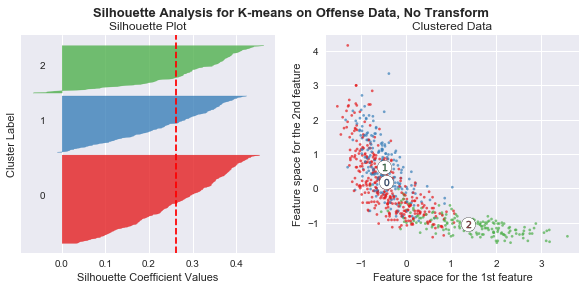

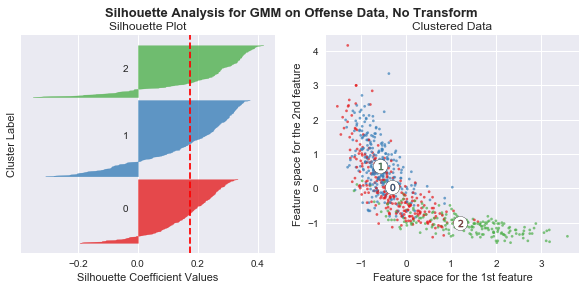

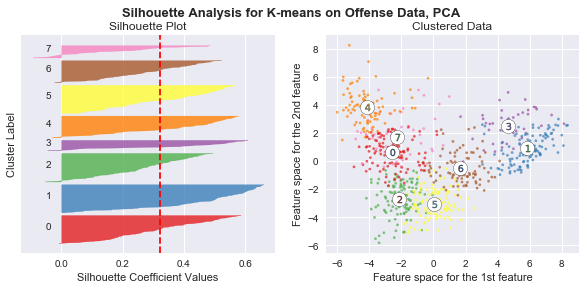

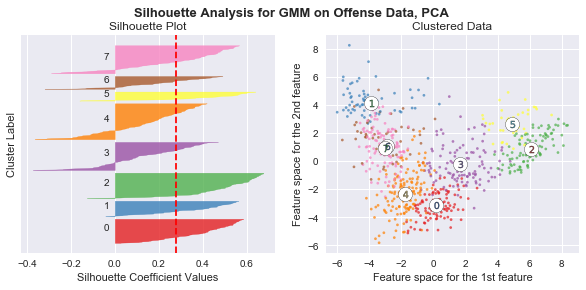

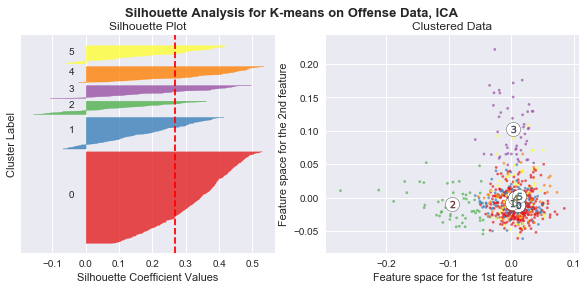

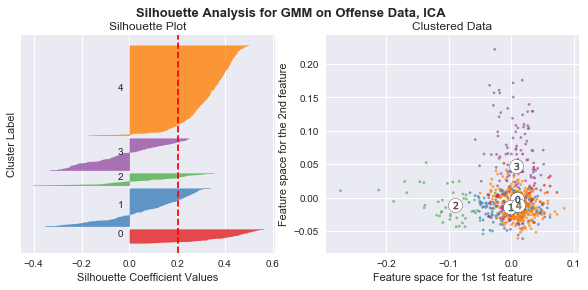

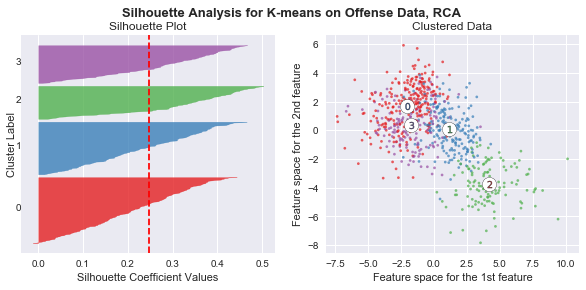

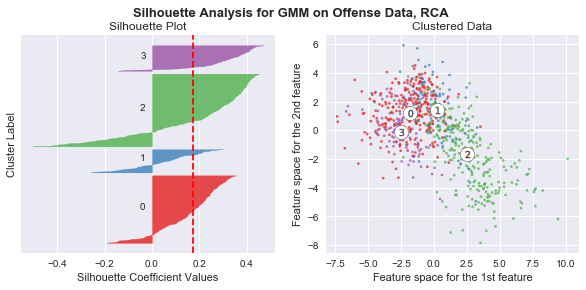

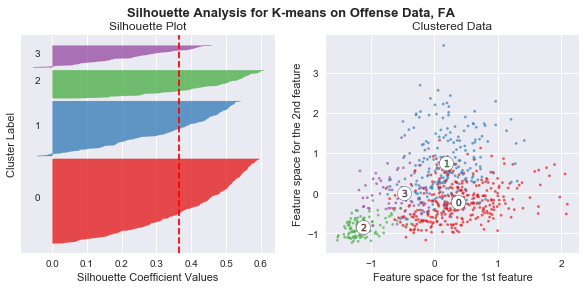

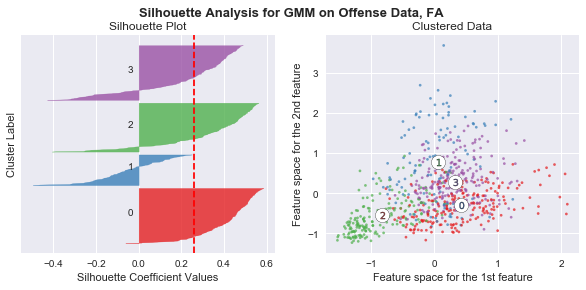

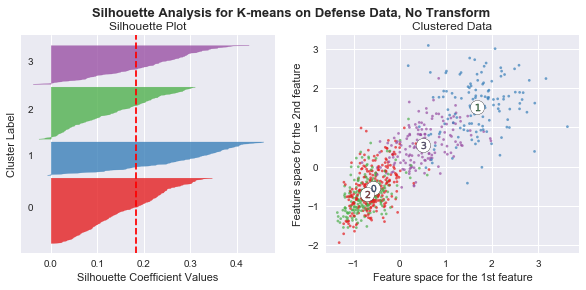

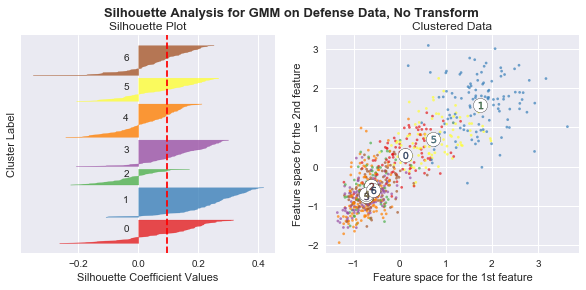

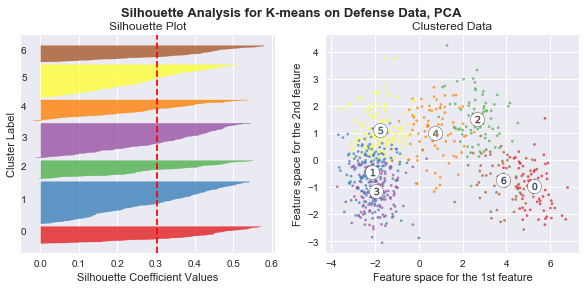

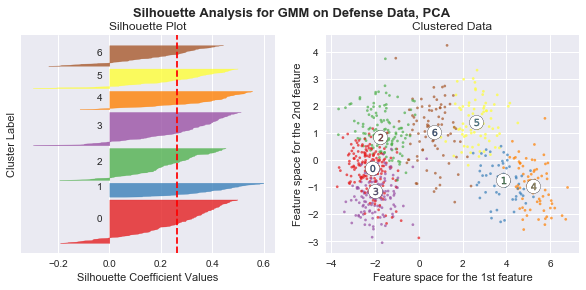

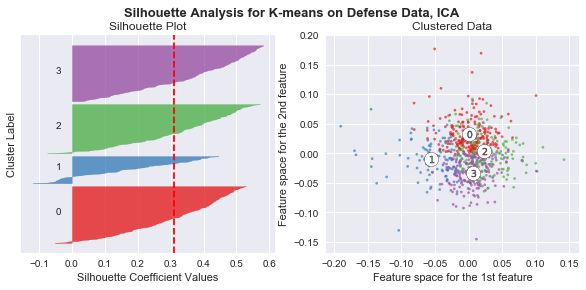

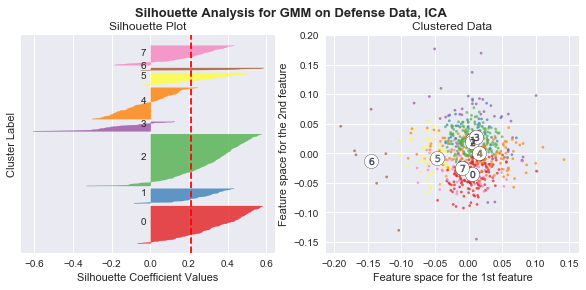

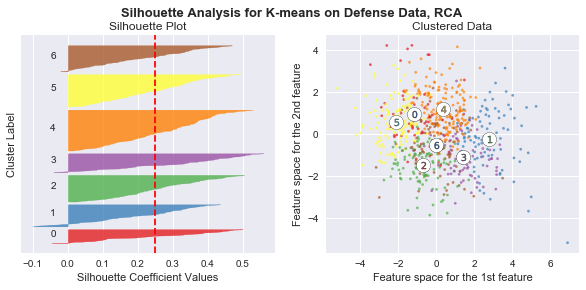

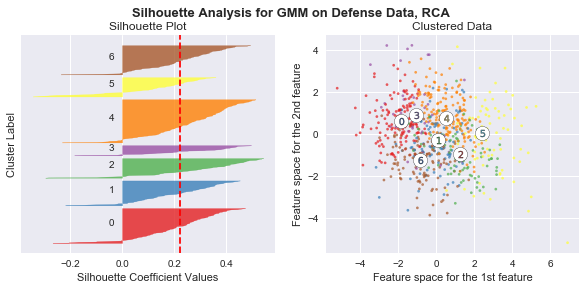

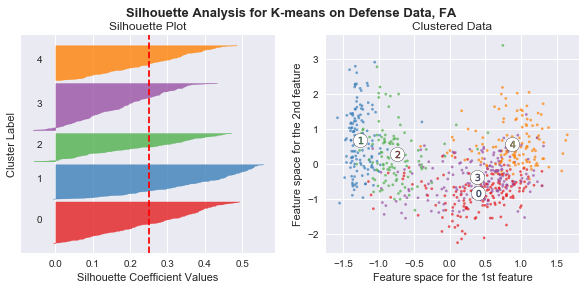

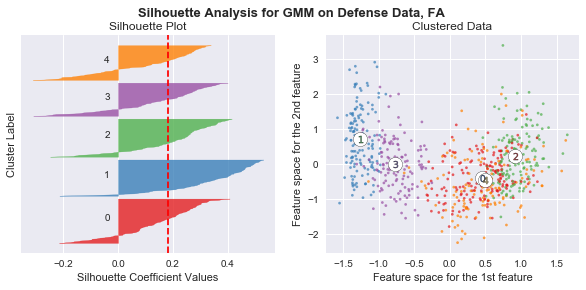

In [389]:
data_dict = {'Offense':{'No Transform':[Xo_norm, 3, 3],
                        'PCA':[dfpcao[['PC1', 'PC2', 'PC3']].values, 8, 8],
                        'ICA':[dficao.values, 6, 5],
                        'RCA':[dfrcao.values, 4, 4],
                        'FA':[dffao.values, 4, 4]
                       },
             'Defense':{'No Transform':[Xd_norm, 4, 7],
                        'PCA':[dfpcad[['PC1', 'PC2', 'PC3']].values, 7, 7],
                        'ICA':[dficad.values, 4, 8],
                        'RCA':[dfrcad.values, 7, 7],
                        'FA':[dffad.values, 5, 5]
                       }
            }

for side, data_dict in data_dict.items():
    for transform, d in data_dict.items():
        silhouette(d[1], d[0],
                   'Silhouette Analysis for K-means on {0} Data, {1}'.format(side, transform),
                   'Kmeans')
        silhouette(d[2], d[0],
                   'Silhouette Analysis for GMM on {0} Data, {1}'.format(side, transform),
                   'GMM')

In [122]:
def getClusters(df, df_orig, n_clusters, n_comp, cols, name, algo='Kmeans'):
    X = df.iloc[:, 0:n_comp].values
    
    if algo == 'Kmeans':
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
        df['Cluster'] = kmeans.labels_
        df_orig[name] = kmeans.labels_
        centers = kmeans.cluster_centers_
    elif algo == 'GMM':
        gm = gmm(n_components=n_clusters, random_state=0).fit(X)
        df['Cluster'] = gm.predict(X)
        df_orig[name] = gm.predict(X)
        centers = gm.means_
    
    df_orig['Dist'] = 0
    for i in range(n_comp):
        df_orig['Dist'] = df_orig['Dist'] + df.apply(lambda x:
                                                        (x[i] - centers[int(x['Cluster'])][i])**2,
                                                        axis=1)
    df.drop(['Cluster'], inplace=True, axis=1)
    print('-------{}-------'.format(algo))
    print(df_orig.groupby(name).count()['Dist'])
    print(df_orig.groupby([name, 'P']).count()['Dist'])
    print(df_orig.groupby(name).mean()['Dist'])
    print(df_orig.groupby(name).mean()[cols])
    print(df_orig.loc[df_orig.sort_values('Dist',
                                            ascending=False).groupby(name).head().index,
                 ['DISPLAY_FIRST_LAST',
                  'season', name, 'Dist']
                ].sort_values(name))

In [125]:
getClusters(dfpcao, df, 8, 3, ocols, 'PCA_Cluster_O', 'Kmeans')

-------Kmeans-------
PCA_Cluster_O
0    112
1    113
2    115
3     42
4     87
5    113
6     88
7     50
Name: Dist, dtype: int64
PCA_Cluster_O  P  
0              F        6
               G      100
               G-F      6
1              C       62
               F       30
               F-C     20
               G-F      1
2              F       23
               G       73
               G-F     19
3              C       17
               F       13
               F-C     12
4              F        3
               G       84
5              F       80
               F-C      1
               G       18
               G-F     14
6              C       11
               F       58
               F-C     15
               G-F      4
7              F       14
               G       22
               G-F     14
Name: Dist, dtype: int64
PCA_Cluster_O
0    2.987499
1    4.001590
2    3.331612
3    5.612226
4    3.915172
5    2.426119
6    3.687515
7    5.907614
Name: Dist, dtype: flo

In [153]:
getClusters(dfpcad, df, 5, len(dfica.columns), dcols,'PCA_Cluster_D', 'Kmeans')

-------Kmeans-------
PCA_Cluster_D
0    135
1    140
2    175
3    144
4    126
Name: Dist, dtype: int64
PCA_Cluster_D  P  
0              F        5
               G      124
               G-F      6
1              C       12
               F      101
               F-C     20
               G        1
               G-F      6
2              F       42
               G      109
               G-F     24
3              F       59
               G       63
               G-F     22
4              C       78
               F       20
               F-C     28
Name: Dist, dtype: int64
PCA_Cluster_D
0    3.055890
1    4.019667
2    2.915850
3    3.459730
4    3.888006
Name: Dist, dtype: float64
               d_DEF_RIM_FGA  d_DREB_CHANCES  d_AVG_DREB_DIST  \
PCA_Cluster_D                                                   
0                   0.061860        0.179898         8.925926   
1                   0.124679        0.291760         5.377857   
2                   0.064506        0.

In [154]:
getClusters(dfpcad, df, 12, len(dfica.columns), dcols,'PCA_Cluster_D_GMM', 'GMM')

-------GMM-------
PCA_Cluster_D_GMM
0     131
1      91
2      65
3      67
4      33
5      14
6      70
7      74
8      44
9      23
10     38
11     70
Name: Dist, dtype: int64
PCA_Cluster_D_GMM  P  
0                  F      35
                   G      78
                   G-F    18
1                  C      13
                   F      62
                   F-C    13
                   G-F     3
2                  F       2
                   G      59
                   G-F     4
3                  F      21
                   G      36
                   G-F    10
4                  C      24
                   F       1
                   F-C     8
5                  F       5
                   G       7
                   G-F     2
6                  C       1
                   F      51
                   F-C     6
                   G       6
                   G-F     6
7                  F      10
                   G      59
                   G-F     5
8            

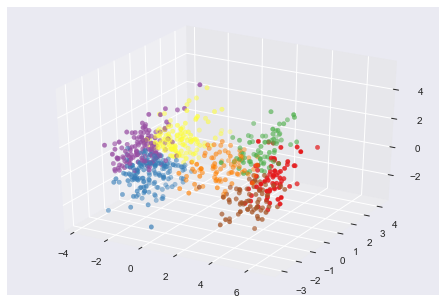

In [129]:
from mpl_toolkits.mplot3d import Axes3D

def plot3D(X, k):
    fig = plt.figure()
    ax = Axes3D(fig)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = kmeans.labels_
    colors2 = [colors[x] for x in labels]
    ax.scatter(X[:,0], X[:,1], X[:,2], c = colors2)
    
plot3D(dfpcad[['PC1', 'PC2', 'PC3']].values, 7)